In [304]:
import numpy as np
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random
import jax.numpy as jnp
from jax.scipy.special import logsumexp, expit
import arviz as az
import seaborn as sns
import scipy

We will first simulate data

In [300]:
def simulation(p11, p_aru11, p_aru01, n_visits, n_points, n_recordings, mu, sigma, beta0, beta1):
    # generate covars
    burn = np.random.normal(size=n_points)

    psi_c = expit(beta0 + beta1 * burn)
    z = np.random.binomial(1, psi_c, size=n_points)

    # generate visits (point counts)
    y_ind = []
    for i in range(n_points):
        pr_y_equals_1 = p11 * z[i]
        y_ind.append(np.random.binomial(n_visits, pr_y_equals_1))

    # generate recordings (ARU samples)
    n_samples = n_recordings * n_points
    y_aru = []
    for i in range(n_points):
        pr_y_equals_1 = p_aru11 * z[i] + p_aru01 * (1 - z[i])
        y_aru.append(np.random.binomial(n_samples, pr_y_equals_1))
    
    # simulate ARU scores
    scores = []
    for i in range(n_points):
        for j in range(n_recordings):
            if (z[i] == 1):
                scores.append(np.random.normal(mu[1], sigma[1]))
            if (z[i] == 0):
                scores.append(np.random.normal(mu[0], sigma[0]))

    sites = np.repeat(np.arange(n_points), n_recordings)

    # return data
    data = {
        'y_ind': y_ind,
        'y_aru': y_aru,
        'score': scores,
        'burn': burn,
        'n_sites': n_points,
        'n_samples': len(scores),
        'siteid': sites,
        'n_surveys_pc': n_visits,
        'n_surveys_aru': n_recordings,
        'psi_c': psi_c,
    }
    return data

In [310]:
p11 = 0.5
p_aru11 = 0.7
p_aru01 = 0.05
n_visits = 3
n_points = 80
n_recordings = 24
mu = [-2, 0]
sigma = [0.5, 2]
beta0 = 0
beta1 = 0

data = simulation(p11, p_aru11, p_aru01, n_visits, n_points, n_recordings, mu, sigma, beta0, beta1)

Array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5], dtype=float32)

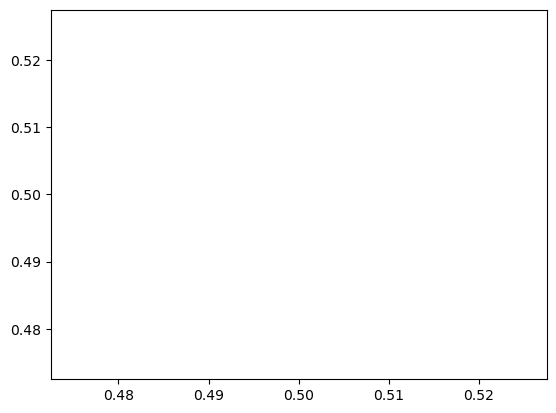

In [314]:
x = data['psi_c']
y = expit(beta0 + beta1 * x)
plt.plot(x,y)
y

In [315]:
def testmodel(y_ind, n_sites, burn):
    beta0 = numpyro.sample('beta0', dist.Normal(0, 1))
    beta1 = numpyro.sample('beta1', dist.Normal(0, 1))
    p11 = numpyro.sample('p11', dist.Beta(2, 2))

    burn = np.array(burn)
    y_ind = np.array(y_ind)
    # latent variables
    psi_c = numpyro.deterministic('psi_c', expit(beta0 + beta1 * burn))
    with numpyro.plate('site', n_sites):
        z = numpyro.sample('z', dist.Bernoulli(psi_c).expand([n_sites]))
    # likelihood
    with numpyro.plate('site', n_sites):
        numpyro.sample('y_ind', dist.Bernoulli(p11 * z), obs=y_ind)


In [316]:
# Testing
nuts_kernel = NUTS(testmodel)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=4000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, data['y_ind'], data['n_sites'], data['burn'])

/var/folders/24/zgsy2wf5421dk08p9vvbh3gc0000gn/T/ipykernel_7251/887955862.py:5: FutureWarning: Some algorithms will automatically enumerate the discrete latent site z of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  mcmc.run(rng_key, data['y_ind'], data['n_sites'], data['burn'])
sample: 100%|██████████| 5000/5000 [00:17<00:00, 282.90it/s, 1023 steps of size 3.51e-04. acc. prob=0.88]


dict_keys(['beta0', 'beta1', 'p11', 'psi_c'])


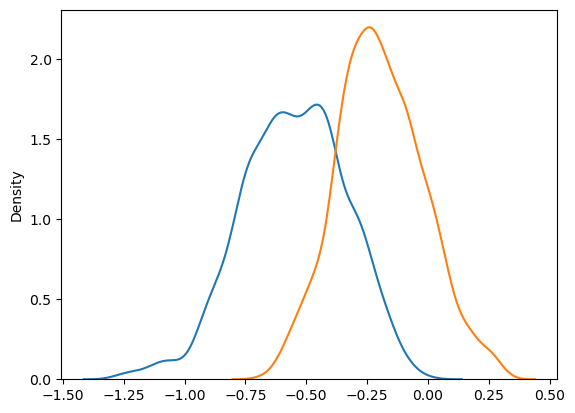

-0.55156577 -0.19540778


In [318]:
# testing
posteriors = mcmc.get_samples()
print(posteriors.keys())
sns.kdeplot(posteriors['beta0'])
sns.kdeplot(posteriors['beta1'])
plt.show()
print(np.mean(posteriors['beta0']), np.mean(posteriors['beta1']))

In [297]:
def model(y_ind, y_aru, score, burn, n_sites, n_samples, siteid):
    # convert to numpy arrays
    burn = np.array(burn)
    y_ind = np.array(y_ind)
    y_aru = np.array(y_aru)
    score = np.array(score)
    siteid = np.array(siteid)
    
    # priors
    beta0 = numpyro.sample('beta0', dist.Normal(0, 1)) # intercept
    beta1 = numpyro.sample('beta1', dist.Normal(0, 1)) # slope
    p11 = numpyro.sample('p11', dist.Beta(2, 2)) # probability of detection
    p_aru11 = numpyro.sample('p_aru11', dist.Beta(2, 2)) # probability of detection for ARU
    p_aru01_unconstrained = numpyro.sample('p_aru01_unconstrained', dist.Beta(1, 3))
    p_aru01 = numpyro.deterministic('p_aru01', jnp.minimum(p_aru01_unconstrained, 1 - p_aru11)) # probability of false positive for ARU

    # scores
    mu0 = numpyro.sample('mu0', dist.Normal(-2, 2))
    mu1 = numpyro.sample('mu1', dist.Normal(-2, 2))
    mu = [mu0, mu1]
    sigma0 = numpyro.sample('sigma0', dist.Uniform(0.1, 5))
    sigma1 = numpyro.sample('sigma1', dist.Uniform(0.1, 5))
    sigma = [sigma0, sigma1]

    # latent variables
    psi_c = numpyro.deterministic('psi_c', expit(beta0 + beta1 * burn))
    with numpyro.plate('site', n_sites):
        z = numpyro.sample('z', dist.Bernoulli(psi_c).expand([n_sites]))
        # likelihood
        numpyro.sample('y_ind', dist.Bernoulli(p11 * z), obs=y_ind)
        numpyro.sample('y_aru', dist.Bernoulli(p_aru11 * z + p_aru01), obs=y_aru)

    # with numpyro.plate('scores', n_samples):
    #     weighted_mu = z[siteid] * mu[1] + (1 - z[siteid]) * mu[0]
    #     weighted_sigma = z[siteid] * sigma[1] + (1 - z[siteid]) * sigma[0]
    #     numpyro.sample('score', dist.Normal(weighted_mu, weighted_sigma), obs=score)

In [298]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=3000)
mcmc.run(random.PRNGKey(0), data['y_ind'], data['y_aru'], data['score'], data['burn'], data['n_sites'], data['n_samples'], data['siteid'])

/var/folders/24/zgsy2wf5421dk08p9vvbh3gc0000gn/T/ipykernel_7251/2558852820.py:3: FutureWarning: Some algorithms will automatically enumerate the discrete latent site z of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  mcmc.run(random.PRNGKey(0), data['y_ind'], data['y_aru'], data['score'], data['burn'], data['n_sites'], data['n_samples'], data['siteid'])
sample: 100%|██████████| 4000/4000 [00:04<00:00, 858.95it/s, 19 steps of size 9.89e-02. acc. prob=0.79] 


dict_keys(['beta0', 'beta1', 'mu0', 'mu1', 'p11', 'p_aru01', 'p_aru01_unconstrained', 'p_aru11', 'psi_c', 'sigma0', 'sigma1'])


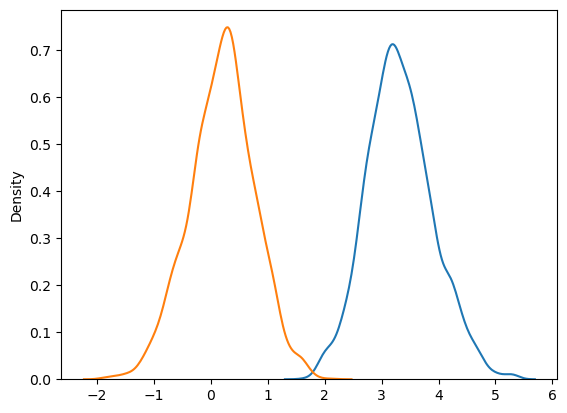

3.3233438


In [299]:
model_posterior = mcmc.get_samples()
print(model_posterior.keys())
sns.kdeplot(model_posterior['beta0'])
sns.kdeplot(model_posterior['beta1'])
plt.show()
print(model_posterior['beta0'].mean())